In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
from PIL import Image

# SimPEG functionality
from simpeg.potential_fields import gravity
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps

# discretize functionality
from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
from scipy.interpolate import griddata

from simpeg import (
    data,
    data_misfit,
    directives,
    inverse_problem,
    inversion,
    maps,
    optimization,
    regularization,
    utils,
)

# Now you can use griddata in your code.

mpl.rcParams.update({"font.size": 14})
import matplotlib.pyplot as plt

save_output = False  # Optional

### Import data set

In [2]:
file_path = "AllBouguerAnomalies_2021Corrected_2022.xlsx"
df = pd.read_excel(file_path, names = ["station", "lat", "lon", "z", "E", "N", "g_abs", "g_corrected",
                                      "elips_g", "fae", "free_air_anomaly", "bouguer_slab", "terrain_faa", "proper_ba","a"])
df

,station,lat,lon,z,E,N,g_abs,g_corrected,elips_g,fae,free_air_anomaly,bouguer_slab,terrain_faa,proper_ba,a
0,C001,49.969703,-123.166620,438.378,488051.4,5535275.5,980842.078,980844.295,981067.653956,-135.283451,-88.075505,-49.042662,10.095541,-77.979964,-127.022626
1,C002,49.971766,-123.177925,620.131,487241.2,5535506.7,980812.173,980814.390,981067.837987,-191.372427,-62.075560,-69.375915,7.062239,-55.013321,-124.389236
2,C003,49.978179,-123.164255,453.277,488223.0,5536217.5,980841.543,980843.760,981068.410150,-139.881282,-84.768868,-50.709458,8.551281,-76.217586,-126.927044
3,C004,49.986146,-123.158343,403.925,488648.7,5537102.4,980851.044,980853.261,981069.120949,-124.651255,-91.208694,-45.188302,9.570324,-81.638370,-126.826671
4,C005,49.978165,-123.186126,664.181,486654.9,5536219.5,980803.461,980805.678,981068.408866,-204.966257,-57.764609,-74.303921,7.777331,-49.987278,-124.291199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,C138,50.106852,-123.276222,1789.303,480247.9,5550547.6,980583.479,980583.479,981079.885441,-552.178906,55.772465,-200.174695,25.057526,80.829991,-119.344703
142,C139,50.047224,-123.285839,1638.384,479534.9,5543920.4,980617.473,980617.473,981074.568829,-505.605302,48.509473,-183.290933,19.774732,68.284205,-115.006728
143,C140,50.044038,-123.255415,1861.171,481711.9,5543558.4,980575.914,980575.914,981074.284759,-574.357371,75.986612,-208.214783,15.801213,91.787825,-116.426958
144,C141,50.072480,-123.212646,1586.419,484783.2,5546711.1,980632.620,980632.620,981076.821016,-489.568903,45.367888,-177.477453,21.034630,66.402518,-111.074935


### Create a meshgrid

In [3]:
# Extract the values for longitude, latitude, z, and bouguerected
lon = df['lon'].values
lat = df['lat'].values
z = df['z'].values
bouguer = df['bouguer_slab'].values

# Create a regular grid for interpolation based on the range of lon and lat
num_points = 100
lon_lin = np.linspace(lon.min(), lon.max(), num_points)
lat_lin = np.linspace(lat.min(), lat.max(), num_points)
grid_lon, grid_lat = np.meshgrid(lon_lin, lat_lin)

# Interpolate z and bouguerected onto the regular grid using cubic interpolation
grid_z = griddata((lon, lat), z, (grid_lon, grid_lat), method='cubic')
# Interpolate with linear first
grid_bouguer = griddata((lon, lat), bouguer, (grid_lon, grid_lat), method='linear')

# # Fill NaNs using nearest
# nan_mask_z = np.isnan(grid_z)
# nan_mask_b = np.isnan(grid_bouguer)

# grid_z[nan_mask_z] = griddata((lon, lat), z, (grid_lon, grid_lat), method='nearest')[nan_mask]
# grid_bouguer[nan_mask_b] = griddata((lon, lat), bouguer, (grid_lon, grid_lat), method='nearest')[nan_mask]


print("Max:", np.nanmax(grid_bouguer))
# bouguer

Max: -5.5847306683322


### plot imported data

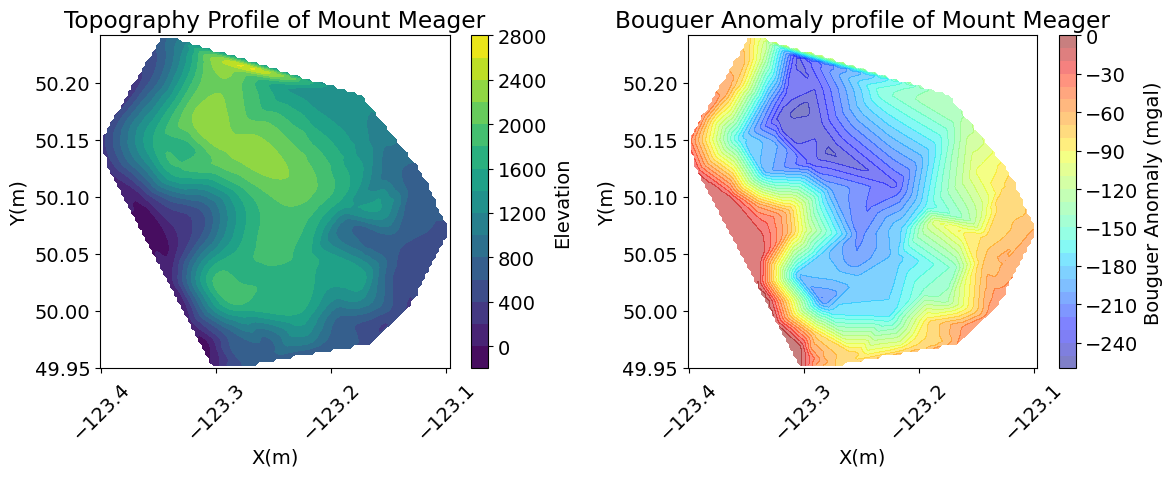

Min: -254.11270418998785
Max: -5.5847306683322


In [4]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ctr1 = ax[0].contourf(grid_lon, grid_lat, grid_z, cmap='viridis', levels=15)
ax[0].set_title("Topography Profile of Mount Meager")
ax[0].set_xlabel("X(m)")
ax[0].set_ylabel("Y(m)")
ax[0].tick_params(axis='x', labelrotation=45)
fig.colorbar(ctr1, ax=ax[0], label="Elevation")

ctr2 = ax[1].contourf(grid_lon, grid_lat, grid_bouguer, cmap='jet',alpha=0.5, levels=30)
ax[1].set_title("Bouguer Anomaly profile of Mount Meager")
ax[1].set_xlabel("X(m)")
ax[1].set_ylabel("Y(m)")

ax[1].tick_params(axis='x', labelrotation=45)
fig.colorbar(ctr2, ax=ax[1], label="Bouguer Anomaly (mgal)")

plt.tight_layout()
plt.show()

print("Min:", np.nanmin(grid_bouguer))
print("Max:", np.nanmax(grid_bouguer))


### Define the Survey

In [5]:
import numpy as np

lat_degree = 50    # degrees (latitude extent)
lon_degree = 123   # degrees (longitude extent)

earth_radius = 6378e3  # Earth's radius in meters

# Conversion factor for one degree (at the equator) in meters:
m_per_degree = (2 * np.pi * earth_radius) / 360

# Distance for a given latitude difference (nearly constant on a spherical Earth)
lat_distance_m = lat_degree * m_per_degree

# Distance for a given longitude difference at a specific latitude:
lon_distance_m = lon_degree * m_per_degree * np.cos(np.deg2rad(50))

print("Latitude conversion:", lat_distance_m, "meters")
print("Longitude conversion at 50° latitude:", lon_distance_m, "meters")


Latitude conversion: 5565854.984609918 meters
Longitude conversion at 50° latitude: 8801050.048691526 meters


In [6]:
x_median = -123.213138
grid_x = grid_lon * m_per_degree  * np.cos(np.deg2rad(50)) - x_median * m_per_degree  * np.cos(np.deg2rad(50))
# grid_x_km = grid_x/1000

y_median = 50.080
grid_y = grid_lat * m_per_degree - y_median * m_per_degree
# grid_y_km = grid_y/1000

In [7]:
x = lon * m_per_degree  * np.cos(np.deg2rad(50)) - x_median * m_per_degree  * np.cos(np.deg2rad(50))
y = lat * m_per_degree - y_median * m_per_degree

x_topo, y_topo, z_topo = mkvc(x), mkvc(y), mkvc(z)
topo_xyz = np.c_[x_topo, y_topo, z_topo]


# Load field data (xyz file)
dobs = grid_bouguer


In [8]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [9]:
# Flatten the grid into coordinate pairs
flat_x = grid_x.flatten()
flat_y = grid_y.flatten()
flat_z = grid_z.flatten()

# Remove any points with NaNs
valid_mask = np.isfinite(flat_z) & np.isfinite(grid_bouguer.flatten())
receiver_locations = np.c_[flat_x[valid_mask], flat_y[valid_mask], flat_z[valid_mask]]
dobs = grid_bouguer.flatten()[valid_mask]


In [10]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

### Design a tensor mesh

In [11]:
# Generate tensor mesh with top at z = 0 m
dh = 300.0  # minimum cell size
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along x
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along y
hz = [(dh, 5, -1.3), (dh, 15)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.array([0.0, 0.0, np.max(topo_xyz[:, 2])])

# tensor_mesh.origin += np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

In [12]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)

n_tensor_active = int(active_tensor_cells.sum())


In [13]:
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

In [14]:
starting_tensor_model =  np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [15]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

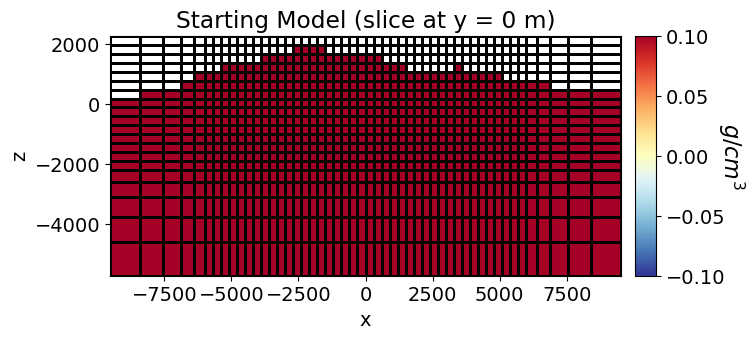

In [16]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

### Define a topography

### Define a survey

In [17]:
# Define the receivers. The data consists of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [18]:
# Find the indices of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(tensor_mesh, topo_xyz)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = np.zeros(nC)

In [19]:
maximum_anomaly = np.max(np.abs(dobs))

uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs))

In [20]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

In [21]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey, mesh=tensor_mesh, rhoMap=model_map, active_cells=ind_active
)

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

In [22]:
# inversion directives
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# The directives are defined as a list
directives_list = [
    update_IRLS,
    starting_beta,
    save_iteration,
    update_jacobi,
]

# Define the regularization (model objective function) with depth weighting.
reg_dpth = regularization.Sparse(tensor_mesh, active_cells=ind_active, mapping=model_map)
reg_dpth.norms = [0, 2, 2, 2]
depth_weights = utils.depth_weighting(
    tensor_mesh, receiver_locations, active_cells=ind_active, exponent=2
)
reg_dpth.set_weights(depth_weights=depth_weights)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg_dpth, opt)

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model_dpth = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/Users/mirei/miniconda3/envs/eosc211/lib/python3.10/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.30e-06  2.42e+07  0.00e+00  2.42e+07    2.05e+02      0              
   1  6.50e-07  1.08e+07  7.11e+10  1.08e+07    1.61e+02      0              
   2  3.25e-07  9.30e+06  1.30e+11  9.34e+06    1.90e+02      0   Skip BFGS  
   3  1.62e-07  6.20e+06  1.72e+11  6.23e+06    1.65e+02      0   Skip BFGS  
   4  8.12e-08  4.88e+06  2.00e+11  4.89e+06    1.37e+02      0   Skip BFGS  
   5  4.06e-08  4.54e+06  2.25e+11  4.55e+06    9.76e+01      0   Skip BFGS  
   6  2.03e-08  4.50e+06  2.47e+11  4.51e+06    1.47e+02      0   Skip BFGS  
   7  1.02e-08  4.49e+06  2.67e+11  4.49e+06    1.58e+02      0   Skip BFGS  
   8  5.08e-09  4.48e+06  2.55e+11  4.48e+06    1.02e+02      5              
------------------------

In [ ]:
# inversion directives
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# The directives are defined as a list
directives_list = [
    update_IRLS,
    starting_beta,
    save_iteration,
    update_jacobi,
]

# Define the regularization (model objective function) with distance weighting.
reg_dist = regularization.Sparse(tensor_mesh, active_cells=ind_active, mapping=model_map)
reg_dist.norms = [0, 2, 2, 2]
distance_weights = utils.distance_weighting(
    tensor_mesh, receiver_locations, active_cells=ind_active, exponent=2
)
reg_dist.set_weights(distance_weights=distance_weights)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg_dist, opt)

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model_dist = inv.run(starting_model)


/var/folders/xx/z13_9gks5jj49hvr6ptgdslr0000gn/T/ipykernel_39680/2174984409.py:32: UserWarning: Numba is not installed. Distance computations will be slower.
  distance_weights = utils.distance_weighting(


In [ ]:
# inversion directives
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list
directives_list = [
    update_IRLS,
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_jacobi,
]

# Define the regularization (model objective function) for sensitivity weighting.
reg_sensw = regularization.Sparse(tensor_mesh, active_cells=ind_active, mapping=model_map)
reg_sensw.norms = [0, 2, 2, 2]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg_sensw, opt)

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model_sensw = inv.run(starting_model)

In [ ]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.2
sphere_density = 0.2

# Define model. Models in simpeg are vector arrays.
true_model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (tensor_mesh.gridCC[ind_active, 0] > -50.0)
    & (tensor_mesh.gridCC[ind_active, 0] < -20.0)
    & (tensor_mesh.gridCC[ind_active, 1] > -15.0)
    & (tensor_mesh.gridCC[ind_active, 1] < 15.0)
    & (tensor_mesh.gridCC[ind_active, 2] > -50.0)
    & (tensor_mesh.gridCC[ind_active, 2] < -30.0)
)
true_model[ind_block] = block_density

# You can also use simpeg utilities to add structures to the model more concisely
ind_sphere = model_builder.get_indices_sphere(
    np.r_[35.0, 0.0, -40.0], 15.0, tensor_mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]
true_model[ind_sphere] = sphere_density

In [ ]:
# Plot Models
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
ax = ax.flatten()
plotting_map = maps.InjectActiveCells(tensor_mesh, ind_active, np.nan)
cmap = "coolwarm"
slice_y_loc = 0.0

mm = tensor_mesh.plot_slice(
    plotting_map * true_model,
    normal="Y",
    ax=ax[0],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[0].set_title(f"True model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[0])

# plot depth weighting result
vmax = np.abs(recovered_model_dpth).max()
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)
mm = tensor_mesh.plot_slice(
    plotting_map * recovered_model_dpth,
    normal="Y",
    ax=ax[1],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[1].set_title(f"Depth weighting Model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[1])

# plot distance weighting result
vmax = np.abs(recovered_model_dist).max()
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)
mm = tensor_mesh.plot_slice(
    plotting_map * recovered_model_dist,
    normal="Y",
    ax=ax[2],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[2].set_title(f"Distance weighting Model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[2])

# plot sensitivity weighting result
vmax = np.abs(recovered_model_sensw).max()
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)
mm = tensor_mesh.plot_slice(
    plotting_map * recovered_model_sensw,
    normal="Y",
    ax=ax[3],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[3].set_title(f"Sensitivity weighting Model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[3])

# shared plotting
plotting_map = maps.InjectActiveCells(tensor_mesh, ind_active, 0.0)
# slice_y_ind = (
#     tensor_mesh.cell_centers[:, 1] == np.abs(tensor_mesh.cell_centers[:, 1] - slice_y_loc).min()
# )

slice_y_ind = np.argmin(np.abs(tensor_mesh.cell_centers[:, 1] - slice_y_loc))
# slice_y_coords = tensor_mesh.cell_centers[:, 1] == tensor_mesh.cell_centers[slice_y_ind, 1]


for axx in ax:
    utils.plot2Ddata(
        tensor_mesh.cell_centers[slice_y_coords][:, [0, 2]],
        (plotting_map * true_model)[slice_y_coords],
        contourOpts={"alpha": 0, "levels": [-0.2, 0.2]},
        level=True,
        ncontour=2,
        levelOpts={"colors": "grey", "linewidths": 2, "linestyles": "--"},
        method="nearest",
        ax=axx,
    )
    axx.set_aspect(1)

plt.tight_layout()